=== URGENT CARE IMAGE DATASET RECREATION ===
Using Kaggle API (compatible with kagglehub 0.1.4)

Step 1: Downloading datasets from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/shubhambaid/skin-burn-dataset
✓ Downloaded shubhambaid/skin-burn-dataset
Dataset URL: https://www.kaggle.com/datasets/faresabbasai2022/skin-burn-dataset
✓ Downloaded faresabbasai2022/skin-burn-dataset
Dataset URL: https://www.kaggle.com/datasets/ibrahimfateen/wound-classification
✓ Downloaded ibrahimfateen/wound-classification
Dataset URL: https://www.kaggle.com/datasets/yasinpratomo/wound-dataset
✓ Downloaded yasinpratomo/wound-dataset

Dataset paths:
  Burn Dataset: burn_dataset
  Alt Burn Dataset: alt_burn_dataset
  Wound Dataset: wound_dataset
  Yasin Dataset: yasin_dataset

Step 2: Analyzing dataset structures...
Dataset: burn_dataset
  Number of images: 1227
  Number of subfolders: 1
  Subfolders: ['.']
  Example image files: ['img186.jpg', 'img1048.jpg', 'img1400.jpg']

Dataset: alt_burn_dataset


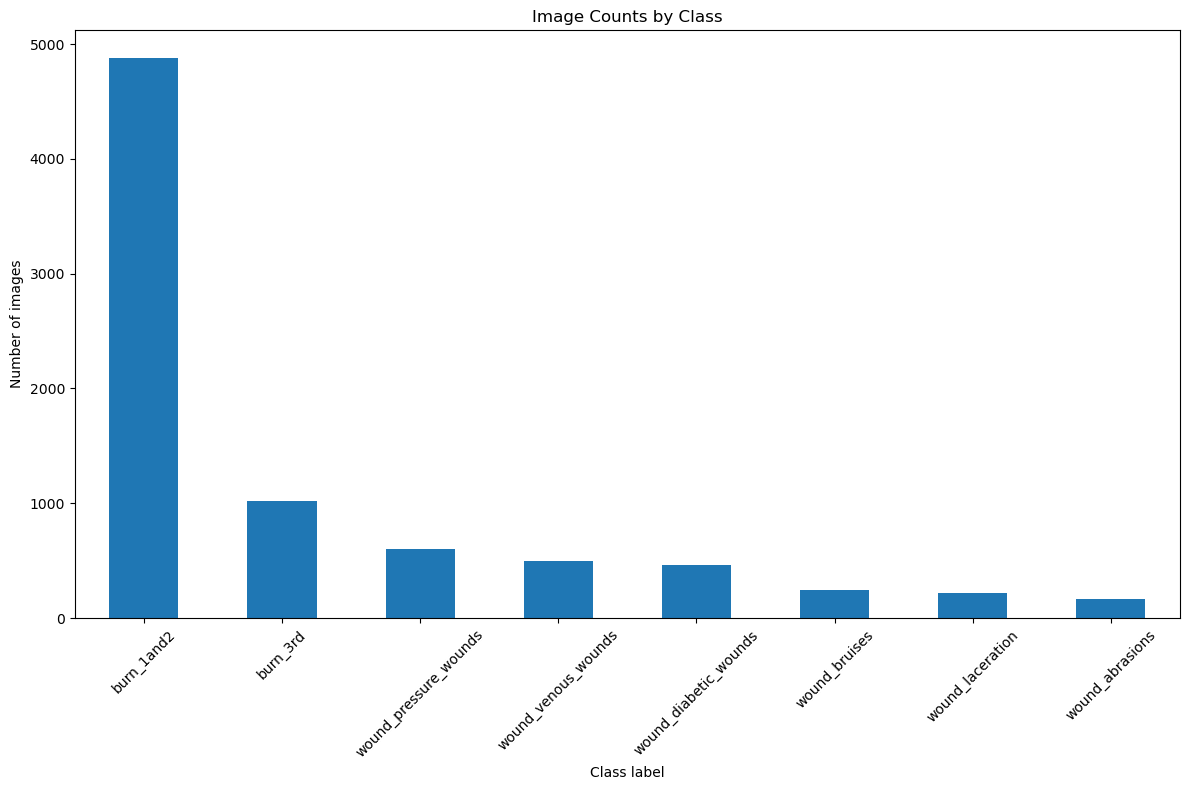

Saved class_distribution.png

=== DATASET RECREATION COMPLETE ===
Final dataset contains 8085 images across 8 classes
Files created:
  ✓ burns_1and2.csv
  ✓ burns_3rd.csv
  ✓ burns_unknown_degree.csv
  ✓ wounds.csv
  ✓ urgent_care_images_master.csv
  ✓ urgent_care_images_master_no_wound_burns.csv
  ✓ urgent_care_images_master_plus_yasin.csv
  ✓ urgent_care_images_master_final.csv
  ✓ class_distribution.png


In [1]:
#!/usr/bin/env python3
"""
Urgent Care Image Dataset Recreation Script - Using Kaggle API
Compatible with kagglehub 0.1.4 (uses traditional kaggle API for datasets)
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

def setup_kaggle_credentials():
    """Set up Kaggle credentials if not already configured"""
    try:
        import kaggle
        from kaggle.api.kaggle_api_extended import KaggleApi
        
        api = KaggleApi()
        api.authenticate()
        return api
    except OSError as e:
        if "credentials" in str(e).lower():
            print("Kaggle credentials not found!")
            print("Please set up your Kaggle credentials:")
            print("1. Go to https://www.kaggle.com/settings")
            print("2. Click 'Create New API Token'") 
            print("3. Download kaggle.json")
            print("4. Place it at ~/.kaggle/kaggle.json (Linux/Mac) or C:\\Users\\{username}\\.kaggle\\kaggle.json (Windows)")
            print("5. Or set environment variables:")
            print("   os.environ['KAGGLE_USERNAME'] = 'your_username'")
            print("   os.environ['KAGGLE_KEY'] = 'your_api_key'")
            return None
        else:
            raise e

def download_datasets():
    """Download all required datasets using Kaggle API"""
    api = setup_kaggle_credentials()
    if not api:
        return None
    
    # Dataset specifications: (kaggle_name, local_folder_name)
    datasets = [
        ("shubhambaid/skin-burn-dataset", "burn_dataset"),
        ("faresabbasai2022/skin-burn-dataset", "alt_burn_dataset"), 
        ("ibrahimfateen/wound-classification", "wound_dataset"),
        ("yasinpratomo/wound-dataset", "yasin_dataset")
    ]
    
    paths = []
    
    for dataset_name, folder_name in datasets:
        print(f"Downloading {dataset_name} to {folder_name}...")
        try:
            # Create directory if it doesn't exist
            os.makedirs(folder_name, exist_ok=True)
            
            # Download and unzip
            api.dataset_download_files(dataset_name, path=folder_name, unzip=True)
            paths.append(folder_name)
            print(f"✓ Downloaded {dataset_name}")
            
        except Exception as e:
            print(f"✗ Failed to download {dataset_name}: {e}")
            return None
    
    return tuple(paths)

def summarize_dataset(folder):
    """Summarize dataset structure and image counts"""
    if not os.path.exists(folder):
        print(f"Warning: {folder} does not exist")
        return
        
    image_exts = ('.jpg', '.jpeg', '.png')
    image_count = 0
    subfolders = set()
    sample_images = []
    
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(image_exts):
                image_count += 1
                subfolders.add(os.path.relpath(root, folder))
                # Save up to 3 sample file paths
                if len(sample_images) < 3:
                    sample_images.append(os.path.relpath(os.path.join(root, f), folder))
    
    print(f"Dataset: {folder}")
    print(f"  Number of images: {image_count}")
    print(f"  Number of subfolders: {len(subfolders)}")
    print(f"  Subfolders: {list(subfolders)[:5]}{' ...' if len(subfolders) > 5 else ''}")
    print(f"  Example image files: {sample_images}")
    print("")

def find_dataset_subpath(base_path, possible_subpaths):
    """Find the correct subpath within a dataset"""
    for subpath in possible_subpaths:
        full_path = os.path.join(base_path, subpath)
        if os.path.exists(full_path):
            return full_path
    return base_path

def collect_burn_images(root_folder):
    """Collect burn images and categorize by degree"""
    data_1and2 = []
    data_3 = []
    
    if not os.path.exists(root_folder):
        print(f"Warning: {root_folder} does not exist. Skipping...")
        return data_1and2, data_3
    
    for degree_folder in os.listdir(root_folder):
        full_path = os.path.join(root_folder, degree_folder)
        if not os.path.isdir(full_path):
            continue
            
        if "1st" in degree_folder or "2nd" in degree_folder:
            label = "1_and_2_degree"
            target_list = data_1and2
        elif "3nd" in degree_folder or "3rd" in degree_folder:
            label = "3rd_degree"
            target_list = data_3
        else:
            continue
            
        for f in os.listdir(full_path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                target_list.append({
                    "filepath": os.path.join(full_path, f),
                    "label": label
                })
    
    return data_1and2, data_3

def collect_wound_images(wound_root):
    """Collect wound images from Ibrahim Fateen dataset"""
    data = []
    
    if not os.path.exists(wound_root):
        print(f"Warning: {wound_root} does not exist. Skipping...")
        return pd.DataFrame(data)
    
    for category_folder in os.listdir(wound_root):
        full_path = os.path.join(wound_root, category_folder)
        if not os.path.isdir(full_path):
            continue
        
        label = f"wound_{category_folder.replace(' ', '_').lower()}"  # e.g. wound_abrasions
        for f in os.listdir(full_path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                data.append({
                    "filepath": os.path.join(full_path, f),
                    "label": label
                })
    
    return pd.DataFrame(data)

def collect_yasin_wound_images(wound_root):
    """Collect wound images from Yasin Pratomo dataset"""
    data = []
    
    if not os.path.exists(wound_root):
        print(f"Warning: {wound_root} does not exist. Skipping...")
        return pd.DataFrame(data)
    
    for folder in os.listdir(wound_root):
        subfolder = os.path.join(wound_root, folder)
        if not os.path.isdir(subfolder):
            continue
        
        label = f"wound_{folder.lower()}"  # E.g., wound_abrasions
        files = [f for f in os.listdir(subfolder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for f in files:
            data.append({
                "filepath": os.path.join(subfolder, f),
                "label": label
            })
    
    return pd.DataFrame(data)

def remap_label(label):
    """Standardize label names and merge similar categories"""
    if label in ["wound_laceration", "wound_laseration", "wound_stab_wound", "wound_cut"]:
        return "wound_laceration"
    return label

def main():
    """Main execution function"""
    print("=== URGENT CARE IMAGE DATASET RECREATION ===")
    print("Using Kaggle API (compatible with kagglehub 0.1.4)\n")
    
    # Step 1: Download datasets
    print("Step 1: Downloading datasets from Kaggle...")
    
    paths = download_datasets()
    if not paths:
        print("Failed to download datasets. Exiting.")
        return
    
    burn_path, alt_burn_path, wound_path, yasin_path = paths
    
    print(f"\nDataset paths:")
    print(f"  Burn Dataset: {burn_path}")
    print(f"  Alt Burn Dataset: {alt_burn_path}")
    print(f"  Wound Dataset: {wound_path}")
    print(f"  Yasin Dataset: {yasin_path}")
    
    # Step 2: Summarize datasets
    print("\nStep 2: Analyzing dataset structures...")
    summarize_dataset(burn_path)
    summarize_dataset(alt_burn_path)
    summarize_dataset(wound_path)
    summarize_dataset(yasin_path)
    
    # Step 3: Process burn datasets
    print("Step 3: Processing burn datasets...")
    
    # Find the correct paths for alternative burn dataset
    possible_train_paths = [
        "skin burn dataset/train",
        "train",
        "skin-burn-dataset/train"
    ]
    possible_valid_paths = [
        "skin burn dataset/valid", 
        "valid",
        "skin-burn-dataset/valid"
    ]
    
    train_root = find_dataset_subpath(alt_burn_path, possible_train_paths)
    valid_root = find_dataset_subpath(alt_burn_path, possible_valid_paths)
    
    print(f"Using train path: {train_root}")
    print(f"Using valid path: {valid_root}")
    
    # Collect burn images by degree
    train_1and2, train_3 = collect_burn_images(train_root)
    valid_1and2, valid_3 = collect_burn_images(valid_root)
    
    # Create DataFrames
    df_1and2 = pd.DataFrame(train_1and2 + valid_1and2)
    df_3 = pd.DataFrame(train_3 + valid_3)
    
    # Process generic burn files (from the first burn dataset)
    if os.path.exists(burn_path):
        generic_burn_files = [f for f in os.listdir(burn_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        df_generic = pd.DataFrame([{
            "filepath": os.path.join(burn_path, f),
            "label": "unknown_degree"
        } for f in generic_burn_files])
    else:
        df_generic = pd.DataFrame()
    
    # Save burn datasets
    df_1and2.to_csv("burns_1and2.csv", index=False)
    df_3.to_csv("burns_3rd.csv", index=False)
    df_generic.to_csv("burns_unknown_degree.csv", index=False)
    
    print("Saved burn files:")
    print(f"  burns_1and2.csv: {len(df_1and2)} images")
    print(f"  burns_3rd.csv: {len(df_3)} images")
    print(f"  burns_unknown_degree.csv: {len(df_generic)} images")
    
    # Step 4: Create combined burn dataset with proper labels
    print("\nStep 4: Creating combined burn dataset...")
    
    # Map to final labels
    df_1and2['label'] = 'burn_1and2'
    df_3['label'] = 'burn_3rd'
    df_burns = pd.concat([df_1and2, df_3], ignore_index=True)
    
    # Step 5: Process wound datasets
    print("Step 5: Processing wound datasets...")
    
    # Find the correct path for Ibrahim Fateen wound dataset
    possible_wound_paths = [
        "Wound_dataset copy",
        "wound_dataset_copy", 
        "Wound_dataset",
        "wound-classification"
    ]
    
    wound_root_ibrahim = find_dataset_subpath(wound_path, possible_wound_paths)
    print(f"Using wound path: {wound_root_ibrahim}")
    
    df_wounds_ibrahim = collect_wound_images(wound_root_ibrahim)
    df_wounds_ibrahim.to_csv("wounds.csv", index=False)
    print(f"Saved wounds.csv: {len(df_wounds_ibrahim)} images")
    
    # Step 6: Create initial master dataset
    print("\nStep 6: Creating initial master dataset...")
    
    # Combine burns and wounds
    df_all = pd.concat([df_burns[['filepath', 'label']], df_wounds_ibrahim[['filepath', 'label']]], ignore_index=True)
    
    print("Initial label distribution:")
    print(df_all['label'].value_counts())
    
    df_all.to_csv("urgent_care_images_master.csv", index=False)
    print(f"Saved urgent_care_images_master.csv: {len(df_all)} total images")
    
    # Step 7: Remove wound_burns to avoid confusion
    print("\nStep 7: Removing wound_burns category...")
    
    before = len(df_all)
    df_all = df_all[df_all['label'] != 'wound_burns'].copy()
    after = len(df_all)
    print(f"Removed {before - after} wound_burns images. Final dataset: {after} images.")
    
    df_all.to_csv('urgent_care_images_master_no_wound_burns.csv', index=False)
    
    # Step 8: Add Yasin wound dataset
    print("\nStep 8: Adding Yasin wound dataset...")
    
    df_yasin = collect_yasin_wound_images(yasin_path)
    print("Yasin dataset shape:", df_yasin.shape)
    if len(df_yasin) > 0:
        print("Yasin labels:", df_yasin['label'].value_counts())
    
    # Combine with existing dataset
    df_all = pd.read_csv("urgent_care_images_master_no_wound_burns.csv")
    print("Old master shape:", df_all.shape)
    
    df_combined = pd.concat([df_all, df_yasin], ignore_index=True)
    print("New combined shape:", df_combined.shape)
    print("Combined labels:")
    print(df_combined['label'].value_counts())
    
    df_combined.to_csv("urgent_care_images_master_plus_yasin.csv", index=False)
    print("Saved as urgent_care_images_master_plus_yasin.csv")
    
    # Step 9: Final cleaning and standardization
    print("\nStep 9: Final cleaning and standardization...")
    
    # Remove unwanted classes
    remove_labels = [
        "wound_burns",
        "wound_ingrown_nails", 
        "wound_normal",
        "wound_surgical_wounds",
    ]
    
    df = df_combined[~df_combined['label'].isin(remove_labels)].copy()
    
    # Standardize labels
    df['label'] = df['label'].apply(remap_label)
    
    print("Cleaned classes:")
    print(df['label'].value_counts())
    
    # Step 10: Save final dataset
    print("\nStep 10: Saving final dataset...")
    
    df.to_csv("urgent_care_images_master_final.csv", index=False)
    print("Saved as urgent_care_images_master_final.csv")
    print("Final class distribution:")
    print(df['label'].value_counts())
    
    # Step 11: Create visualization
    print("\nStep 11: Creating class distribution visualization...")
    
    try:
        plt.figure(figsize=(12, 8))
        df['label'].value_counts().plot(kind='bar', title="Image Counts by Class")
        plt.xlabel("Class label")
        plt.ylabel("Number of images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("class_distribution.png", dpi=300, bbox_inches='tight')
        plt.show()
        print("Saved class_distribution.png")
    except Exception as e:
        print(f"Could not create visualization: {e}")
    
    print("\n=== DATASET RECREATION COMPLETE ===")
    print(f"Final dataset contains {len(df)} images across {df['label'].nunique()} classes")
    print("Files created:")
    files_created = [
        "burns_1and2.csv",
        "burns_3rd.csv", 
        "burns_unknown_degree.csv",
        "wounds.csv",
        "urgent_care_images_master.csv",
        "urgent_care_images_master_no_wound_burns.csv",
        "urgent_care_images_master_plus_yasin.csv",
        "urgent_care_images_master_final.csv",
        "class_distribution.png"
    ]
    
    for file in files_created:
        if os.path.exists(file):
            print(f"  ✓ {file}")
        else:
            print(f"  ✗ {file}")

if __name__ == "__main__":
    # Install the traditional kaggle package if not available
    try:
        import kaggle
    except ImportError:
        print("Installing kaggle package...")
        import subprocess
        subprocess.check_call(["pip", "install", "kaggle"])
        import kaggle
    
    main()

In [2]:
print("All Done")

All Done


In [3]:
# Check what paths are in CSV files
print("=== CHECKING CSV FILE PATHS ===")

print("\n1. Burns 1&2 CSV:")
df_1and2 = pd.read_csv('burns_1and2.csv')
print(f"Shape: {df_1and2.shape}")
print(f"Columns: {df_1and2.columns.tolist()}")
print("Sample filepaths:")
print(df_1and2['filepath'].head())

print("\n2. Burns 3rd CSV:")
df_3 = pd.read_csv('burns_3rd.csv')
print(f"Shape: {df_3.shape}")
print(f"Columns: {df_3.columns.tolist()}")
print("Sample filepaths:")
print(df_3['filepath'].head())

# Check if the directories exist
print("\n3. Checking if directories exist:")
sample_paths = list(df_1and2['filepath'].head()) + list(df_3['filepath'].head())
for path in sample_paths:
    directory = os.path.dirname(path)
    if os.path.exists(directory):
        print(f"✓ Directory exists: {directory}")
    else:
        print(f"✗ Directory missing: {directory}")
        
# Check current directory contents
print(f"\n4. Current directory contents:")
print(os.listdir('.'))

=== CHECKING CSV FILE PATHS ===

1. Burns 1&2 CSV:
Shape: (4876, 2)
Columns: ['filepath', 'label']
Sample filepaths:
0    alt_burn_dataset/skin burn dataset/train/1st d...
1    alt_burn_dataset/skin burn dataset/train/1st d...
2    alt_burn_dataset/skin burn dataset/train/1st d...
3    alt_burn_dataset/skin burn dataset/train/1st d...
4    alt_burn_dataset/skin burn dataset/train/1st d...
Name: filepath, dtype: object

2. Burns 3rd CSV:
Shape: (1023, 2)
Columns: ['filepath', 'label']
Sample filepaths:
0    alt_burn_dataset/skin burn dataset/train/3nd d...
1    alt_burn_dataset/skin burn dataset/train/3nd d...
2    alt_burn_dataset/skin burn dataset/train/3nd d...
3    alt_burn_dataset/skin burn dataset/train/3nd d...
4    alt_burn_dataset/skin burn dataset/train/3nd d...
Name: filepath, dtype: object

3. Checking if directories exist:
✓ Directory exists: alt_burn_dataset/skin burn dataset/train/1st degree burn
✓ Directory exists: alt_burn_dataset/skin burn dataset/train/1st degree burn

In [4]:
# Check individual image files
print("=== CHECKING INDIVIDUAL IMAGE FILES ===")

import random

# Get a sample of actual filepaths
sample_1and2 = df_1and2['filepath'].sample(10).tolist()
sample_3rd = df_3['filepath'].sample(10).tolist()

all_samples = sample_1and2 + sample_3rd

print("Checking sample files:")
missing_files = []
existing_files = []

for filepath in all_samples:
    if os.path.exists(filepath):
        existing_files.append(filepath)
        print(f"✓ {filepath}")
    else:
        missing_files.append(filepath)
        print(f"✗ {filepath}")

print(f"\nSummary:")
print(f"Existing files: {len(existing_files)}")
print(f"Missing files: {len(missing_files)}")

# Let's also check the full datasets for missing files
print(f"\n=== CHECKING ALL FILES (this might take a moment) ===")

all_filepaths = list(df_1and2['filepath']) + list(df_3['filepath'])
total_missing = 0
total_existing = 0

for i, filepath in enumerate(all_filepaths):
    if not os.path.exists(filepath):
        total_missing += 1
        if total_missing <= 10:  # Show first 10 missing files
            print(f"Missing: {filepath}")
    else:
        total_existing += 1
    
    # Progress indicator
    if (i + 1) % 1000 == 0:
        print(f"Checked {i + 1}/{len(all_filepaths)} files...")

print(f"\n=== FINAL RESULTS ===")
print(f"Total files checked: {len(all_filepaths)}")
print(f"Existing files: {total_existing}")
print(f"Missing files: {total_missing}")
print(f"Success rate: {(total_existing/len(all_filepaths)*100):.1f}%")

=== CHECKING INDIVIDUAL IMAGE FILES ===
Checking sample files:
✓ alt_burn_dataset/skin burn dataset/train/1st degree burn/img521_jpg.rf.9cfc793ee1f2df4d98e7de74241fb7a5.jpg
✓ alt_burn_dataset/skin burn dataset/train/2nd degree burn/img42.jpg
✓ alt_burn_dataset/skin burn dataset/train/1st degree burn/img947_jpg.rf.1e1a34f4b7a914465e4766146df4b17b.jpg
✓ alt_burn_dataset/skin burn dataset/train/1st degree burn/img383_jpg.rf.48a08a20c050d4e74cdf5376f5aaa302.jpg
✓ alt_burn_dataset/skin burn dataset/train/2nd degree burn/img1187_jpg.rf.b6afa0be953d81071e7f30486447e25f.jpg
✓ alt_burn_dataset/skin burn dataset/train/1st degree burn/img74_jpg.rf.3a59dfcc71a75bda5d747a2f884fff41.jpg
✓ alt_burn_dataset/skin burn dataset/train/2nd degree burn/img1216_jpg.rf.ed1c7caa3c45921c528611fe1fce48f8.jpg
✓ alt_burn_dataset/skin burn dataset/train/2nd degree burn/img361_jpg.rf.3d3b5f468a283756a73285bcd8f34e16.jpg
✓ alt_burn_dataset/skin burn dataset/train/1st degree burn/img23_jpg.rf.9b49e21545a0f8b9b9208c0e8